# Capstone Project - The Battle of the Neighborhoods (Week 2)
## Applied Data Science Capstone by IBM/Coursera
### Lisbon and Porto Data comparison

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

On this project, I'm going to compare the location data for Lisbon and Porto to see how different they are in the types of venues and neighborhoods differences.

Since Lisbon is one of the most important cities in Europe and in lot's of people tend to set a competition against Porto. If you are looking to set up a company or a cluster of it in Portugal, it is smart to consider where to do it and bring you the best reward, based on your objectives and needs.


# Data <a name="data"></a>

* Portugal's postal codes: https://en.wikipedia.org/wiki/List_of_postal_codes_in_Portugal
* Foursquare location data: https://developer.foursquare.com/

I need to import from the Portugal's postal codes the information for Lisbon and Porto, then save it in a dataframe.

First, let's get the propper libraries for this:

In [72]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.pyplot as plt

#!conda install bs4
#from bs4 import BeautifulSoup #for scrapping information on websites

import math

print('Libraries imported.')

Libraries imported.


In [73]:
#run the line below to be able to work with excel files

#!conda install -c anaconda xlrd --yes

You can export the data from the site using the library beautifulsoup, the problem with doing this for this particular case is that the source code is a little bit confusing. 

When I tried to import every line of code got really messy, I coppied everything and transfered it to an excel file.

This way, we just have to import and clean the data to create a dataframe with the information we need.

If you wish to take a look at the excel file, you can find it on my github repositorie:

* https://github.com/maikelps/Lisbon-vs-Porto-Location-Data-Comparison/blob/master/Postcode.xlsx

Now let's import this file:

In [14]:
#IMPORTING

xl = pd.ExcelFile('Postcode.xlsx')
df1 = xl.parse('Hoja1')
df1 = df1.drop(['Unnamed: 0','b','c','d'], axis=1)
df1.head()

,a
0,Aveiro District[edit]
1,Mealhada Municipality[edit]
2,3050 - Barcouço
3,3050 - Casal Comba
4,3050 - Luso


In [15]:
#CLEANING

df1 = df1.apply(lambda x: x.str.lower().str.strip() if isinstance(x, object) else x) #change all to lowcase because we would need to clean our dataset
df1 = df1.dropna(axis=0) #drop nan values
df1.drop(4574,inplace=True) #drop the last row that has no purpose
df1.tail()

,a
4568,9970 - ponta delgada
4569,9970 - santa cruz das flores
4571,ilha do corvo[edit]
4572,corvo municipality[edit]
4573,9980 - corvo


Now that our temporal dataframe is created let's create a dataframe to save all the data from postcodes in Portugal.

In [16]:
dfpor = pd.DataFrame(columns=['State','Borough','Postcode','Neighborhood'])

for i in range(df1.size):
    
    if "district" in df1.iloc[i,0]:
        state = df1.iloc[i,0].split('district[edit]')[0]
    elif "ilha" in df1.iloc[i,0]:
        state = df1.iloc[i,0].split('[edit')[0]
    elif "municipality" in df1.iloc[i,0]:
        boro = df1.iloc[i,0].split('municipality[edit]')[0]
    else:
        if "-" in state:
            state = dfpor.iloc[-1,0] #some lines get the variable state distorted with neig, we run an extra if to avoid it
        post = df1.iloc[i,0].split('-')[0]
        temp = df1.iloc[i,0].split('-')[0] + '-'
        neig = df1.iloc[i,0].replace(temp, "")
        dfpor = dfpor.append({'State':state, 'Borough':boro, 'Postcode':post , 'Neighborhood':neig}, ignore_index=True)

dfpor.head()

,State,Borough,Postcode,Neighborhood
0,aveiro,mealhada,3050,barcouço
1,aveiro,mealhada,3050,casal comba
2,aveiro,mealhada,3050,luso
3,aveiro,mealhada,3050,"mealhada, ventosa do bairro and antes"
4,aveiro,mealhada,3050,pampilhosa


We will only need the dataframe for the state of our interest, in this case, for the cities Lisbon (Lisboa) and Porto. 

Let's clean our dataset of spaces and extract those dataframes:

In [17]:
#cleaning columns
dfpor['Borough'] = dfpor['Borough'].str.strip()
dfpor['Postcode'] = dfpor['Postcode'].str.strip()
dfpor['State'] = dfpor['State'].str.strip()
dfpor['Neighborhood'] = dfpor['Neighborhood'].str.strip()

In [18]:
dflisb = dfpor[(dfpor['State'] == 'lisboa')] #condition for getting only information about Lisbon
dflisb = dflisb.reset_index(drop=True) #reset index
dflisb = dflisb.drop(['State'], axis=1) #drop state column since is always Lisboa
dflisb['Postcode'][64] = 1170 #fix postal code for row 64, it has two postal codes. Let's keep one

dfporto = dfpor[(dfpor['State'] == 'porto')] #condition for getting only information about Porto
dfporto = dfporto.reset_index(drop=True) #reset index
dfporto = dfporto.drop(['State'], axis=1) #drop state column since is always Porto

print('Shape of Lisbon Dataframe: ', dflisb.shape, '\nShape of Porto Dataframe: ', dfporto.shape)

Shape of Lisbon Dataframe:  (191, 3) 
Shape of Porto Dataframe:  (381, 3)


Now I'll find the coordinates for each Neighborhood using the geolocator object, but sometimes that the object returns a null value, to avoid that, we run multiple times our code in different ways to find the one that fits the most.

Note: _I have some lines with the value "deep", that is to know in which state the geolocator object returned a useful value._

* Let's do it for Lisbon dataframe first:

In [19]:
geolocator = Nominatim(user_agent="lisb_explorer")
dflisb['latitude'] = 0.0
dflisb['longitude'] = 0.0
dflisb['deep'] = 0

for i in range(len(dflisb['Neighborhood'])):
    
    location = geolocator.geocode('{}, {}, Lisbon, Portugal'.format( dflisb['Postcode'][i], dflisb['Neighborhood'][i]) ) 
    dflisb['deep'][i] = 1
    
    if (location is None):
        neig = dflisb['Neighborhood'][i].split(',')[0].split('\xa0')[0] #in case we have more than one value, we use the first only
        location = geolocator.geocode('{}, {}, Lisbon, Portugal'.format( dflisb['Postcode'][i], neig ) )
        dflisb['deep'][i] = 2
    
    if (location is None):
        location = geolocator.geocode('{}, {}, Lisbon, Portugal'.format( dflisb['Postcode'][i], dflisb['Borough'][i]) )
        dflisb['deep'][i] = 3
    
    #worst case:        
    if (location is None):
        location = geolocator.geocode('Lisbon, Portugal')
        dflisb['deep'][i] = 4
    
    dflisb['latitude'][i] = location.latitude
    dflisb['longitude'][i] = location.longitude

dflisb.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterla

,Borough,Postcode,Neighborhood,latitude,longitude,deep
0,alenquer,2580,abrigada,39.145073,-9.020676,1
1,alenquer,2580,aldeia galega da merceana,39.095449,-9.129667,1
2,alenquer,2580,aldeia gavinha,39.089487,-9.088725,1
3,alenquer,2580,cabanas de torres,39.156264,-9.060189,1
4,alenquer,2580,cadafais,39.005411,-9.003039,1


* Let's do the same for Porto dataframe:

In [20]:
geolocator1 = Nominatim(user_agent="porto_explorer")
dfporto['latitude'] = 0.0
dfporto['longitude'] = 0.0
dfporto['deep'] = 0

for i in range(len(dfporto['Neighborhood'])):
    
    location = geolocator1.geocode('{}, {}, Porto, Portugal'.format( dfporto['Postcode'][i], dfporto['Neighborhood'][i]) ) 
    dfporto['deep'][i] = 1
    
    if (location is None):
        location = geolocator1.geocode('{}, {}, Porto, Portugal'.format( dfporto['Postcode'][i], dfporto['Borough'][i]) )
        dfporto['deep'][i] = 2
    
    #worst case:
    if (location is None):
        location = geolocator1.geocode('Porto, Portugal')
        dfporto['deep'][i] = 3
    
    dfporto['latitude'][i] = location.latitude
    dfporto['longitude'][i] = location.longitude

dfporto.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterla

,Borough,Postcode,Neighborhood,latitude,longitude,deep
0,amarante,4600,aboadela,41.282034,-7.963616,1
1,amarante,4600,aboim,41.324137,-8.065268,1
2,amarante,4600,ansiães,41.251357,-7.957065,1
3,amarante,4605,ataíde,41.247620,-8.194434,1
4,amarante,4600,bustelo,41.229999,-8.267715,1


Let's see, in a map, if each value for latitude and longitude is right.

In [21]:
geolocator2 = Nominatim(user_agent="p_explorer")
location = geolocator2.geocode('Portugal')
latitudeT = location.latitude
longitudeT = location.longitude

frames = [dflisb, dfporto]
dfpor2 = pd.concat(frames)

mapa = folium.Map(location=[latitudeT, longitudeT], zoom_start=7)

# add markers to map
for lat, lng, label in zip(dfpor2['latitude'], dfpor2['longitude'], dfpor2['Postcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa)  
    
mapa

Studying at the map we see that some points get are outside Lisbon and Porto for some postcodes. For Lisbon those points are the ones with postal codes 2580, 2710 and 1100. For Porto: 4600, 4610 and 4560.

When looking at the actual data for those post codes and their deep values, I find in some of them a reason for dropping but in others I do not. For simplicity let's drop every row with those postal codes values.

In [22]:
#--- LISBOA ---
#condition for getting only the needed postcodes
dflisb1 = pd.DataFrame(data=dflisb, copy=True)
dflisb1 = dflisb1[( (dflisb['Postcode'] != '2580') & (dflisb1['Postcode'] != '2710') & (dflisb1['Postcode'] != '1100') )]
#reset index
dflisb1 = dflisb1.reset_index(drop=True)

#--- PORTO ---
#condition for getting only the needed postcodes
dfporto1 = pd.DataFrame(data=dfporto, copy=True)
dfporto1 = dfporto1[ (dfporto['Postcode'] != '4600') & (dfporto1['Postcode'] != '4610') & (dfporto1['Postcode'] != '4560') ] #condition for getting only the needed postcodes
#reset index
dfporto1 = dfporto1.reset_index(drop=True) 

print('Shape of Lisbon Dataframe: ', dflisb1.shape, '\nShape of Porto Dataframe: ', dfporto1.shape)

Shape of Lisbon Dataframe:  (171, 6) 
Shape of Porto Dataframe:  (312, 6)


Let's check the map again:

In [23]:
frames = [dflisb1, dfporto1]
dfpor3 = pd.concat(frames)

mapa = folium.Map(location=[latitudeT, longitudeT], zoom_start=7)

# add markers to map
for lat, lng, label in zip(dfpor3['latitude'], dfpor3['longitude'], dfpor3['Postcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa)  
    
mapa

Since the geocode library has a daily limit of calls I install a package for exporting the dataframes into an excel file. That way, in case I reach the limit of calls, I can keep working.

In [20]:
#!conda install -c anaconda openpyxl --yes #library to export a pandas dataframe
#dflisb1.to_excel('dflisbon.xlsx')
#dfporto1.to_excel('dfporto.xlsx')

At this point we have our dataset ready for use with the Foursquare API.

#### Foursquare Data

Let's get the credentials:

In [24]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 700 #limit radius

Now I need the venues for Lisbon and Porto. I'm going to use the code from the labs for such task:

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

To see all the venues in Lisbon:

In [27]:
lisb_venues = getNearbyVenues(names=dflisb1['Neighborhood'],
                                   latitudes=dflisb1['latitude'],
                                   longitudes=dflisb1['longitude']
                                  )

In [28]:
print(lisb_venues.shape)
lisb_venues.head()

(690, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,arranhó,38.953262,-9.134793,Pastelaria Central,38.953148,-9.134832,Café
1,arranhó,38.953262,-9.134793,Sabores da Vila,38.953900,-9.135047,Portuguese Restaurant
2,arruda dos vinhos,38.983030,-9.077630,O Fuso,38.982744,-9.077752,Portuguese Restaurant
3,arruda dos vinhos,38.983030,-9.077630,Nazareth,38.982502,-9.078084,Portuguese Restaurant
4,arruda dos vinhos,38.983030,-9.077630,Doce Arruda,38.982927,-9.078807,Café


Now for Porto:

In [29]:
porto_venues = getNearbyVenues(names=dfporto1['Neighborhood'],
                                   latitudes=dfporto1['latitude'],
                                   longitudes=dfporto1['longitude']
                                  )

In [31]:
print(porto_venues.shape)
porto_venues.head()

(396, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ataíde,41.247620,-8.194434,Padaria Estrela,41.248921,-8.193414,Bakery
1,santa marinha do zêzere,41.141838,-7.950062,O Casarao - Santa Marinha de Zêzere,41.141509,-7.950233,Portuguese Restaurant
2,santa marinha do zêzere,41.141838,-7.950062,Canastra Doce,41.141803,-7.950467,Café
3,santa marinha do zêzere,41.141838,-7.950062,Gare Porto,41.141949,-7.950123,Music Venue
4,santa marinha do zêzere,41.141838,-7.950062,Ideal,41.142310,-7.950372,BBQ Joint


Now, out of curiosity, let's see which Neighborhoods have the top venues for Lisbon and Porto.

In [32]:
lisb_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ericeira,50,50,50,50,50,50
nossa senhora de fátima and são joão de deus,37,37,37,37,37,37
cascais,31,31,31,31,31,31
mártires,29,29,29,29,29,29
santa maria dos olivais,28,28,28,28,28,28


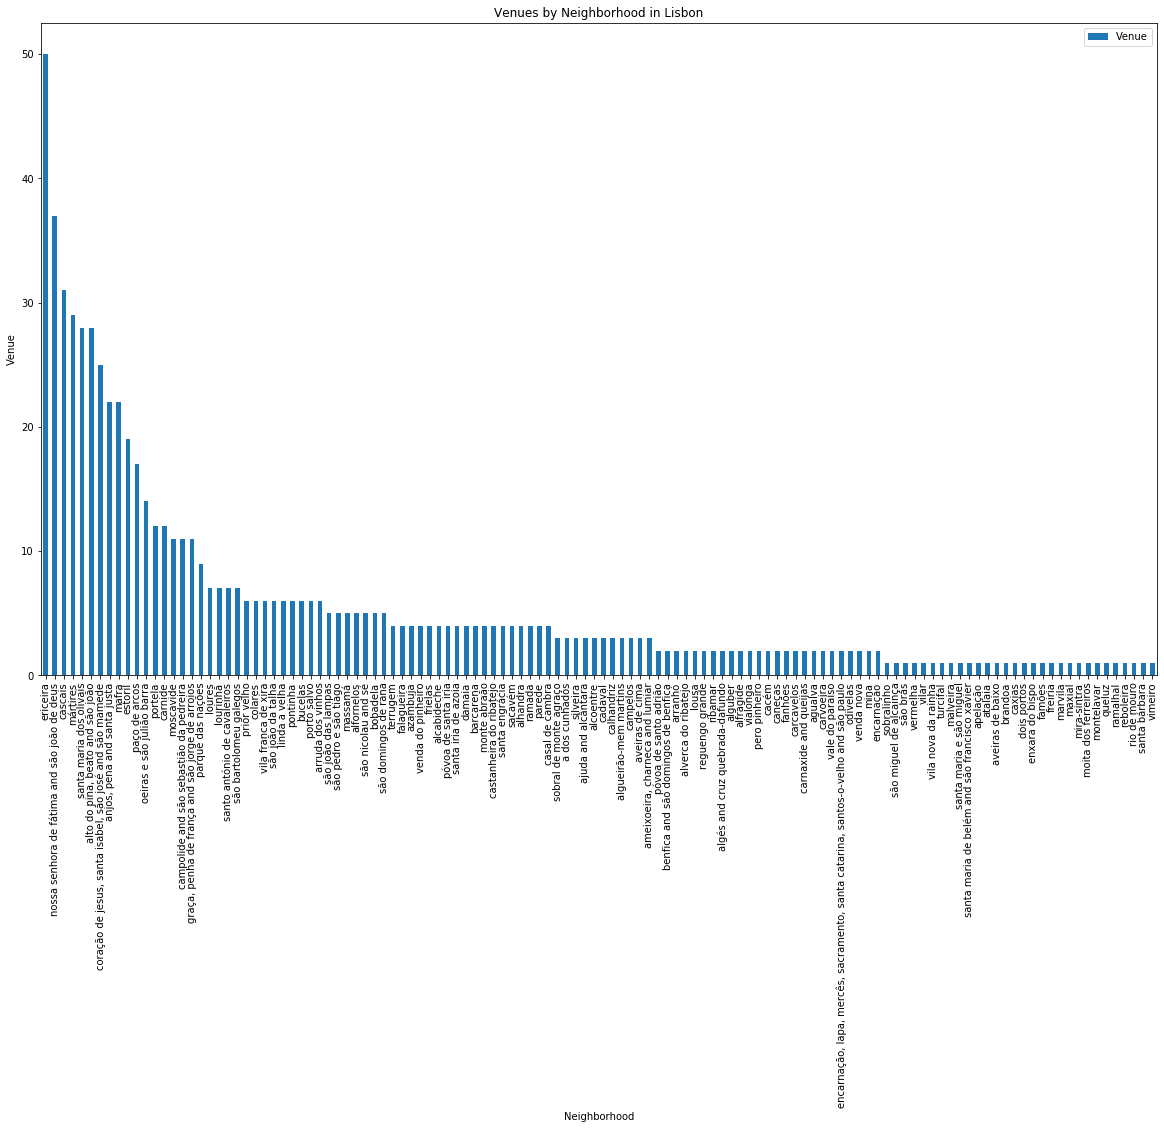

In [93]:
dfl = lisb_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False)
dfl = dfl.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1)

dfl.plot(kind='bar', figsize=(20, 12))

plt.title('Venues by Neighborhood in Lisbon')
plt.ylabel('Venue')
plt.xlabel('Neighborhood')

plt.savefig('Venues_by_Neighborhood_in_Lisbon.png')
plt.show()

In [33]:
porto_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
vitória,73,73,73,73,73,73
santo ildefonso,22,22,22,22,22,22
são nicolau,21,21,21,21,21,21
sé,16,16,16,16,16,16
matosinhos,15,15,15,15,15,15


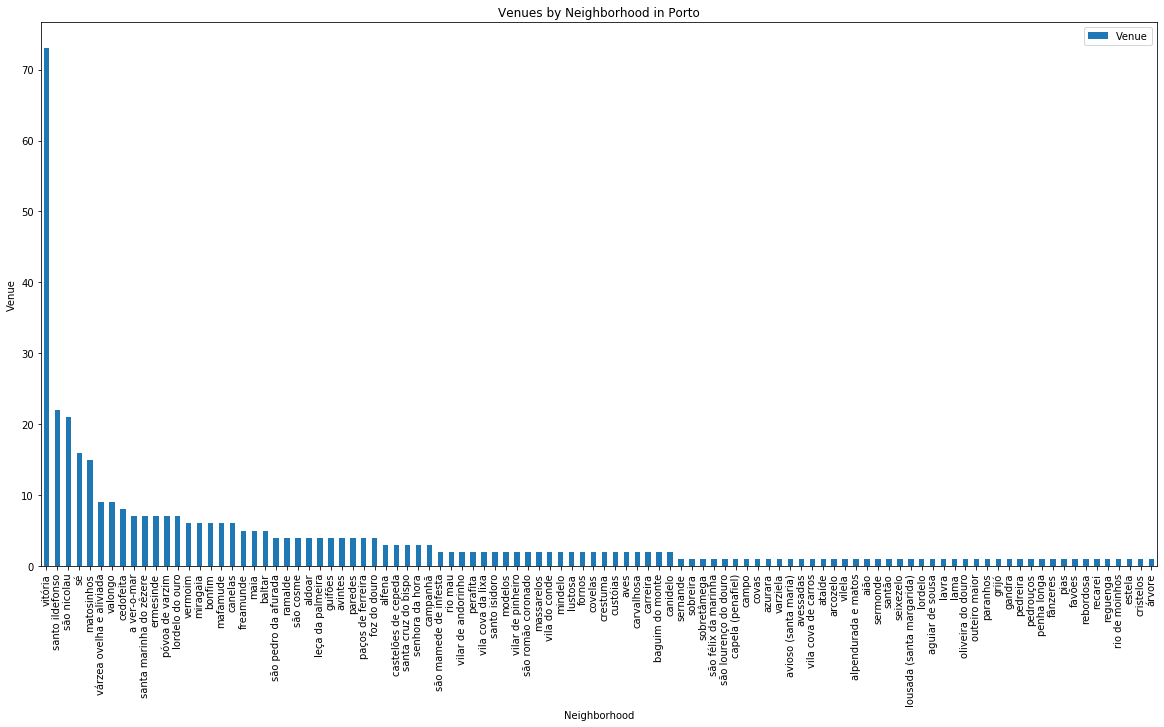

In [92]:
dfp = porto_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False)
dfp = dfp.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1)

dfp.plot(kind='bar', figsize=(20, 10))

plt.title('Venues by Neighborhood in Porto')
plt.ylabel('Venue')
plt.xlabel('Neighborhood')

plt.savefig('Venues_by_Neighborhood_in_Porto.png')
plt.show()

#### Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('For Lisbon there are {} unique categories.'.format(len(lisb_venues['Venue Category'].unique())))
print('For Porto there are {} unique categories.'.format(len(porto_venues['Venue Category'].unique())))

For Lisbon there are 141 unique categories.
For Porto there are 106 unique categories.


### Analyze each Neighborhood (Porto and Lisbon)

In [35]:
# one hot encoding
lisb_onehot = pd.get_dummies(lisb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lisb_onehot['Neighborhood'] = lisb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [lisb_onehot.columns[-1]] + list(lisb_onehot.columns[:-1])
lisb_onehot = lisb_onehot[fixed_columns]

print(lisb_onehot.shape)
lisb_onehot.head()

(690, 142)


,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Bistro,Board Shop,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Casino,Castle,Chinese Restaurant,City,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lake,Lounge,Luggage Store,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Nightclub,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Public Bathroom,Record Shop,Rental Car Location,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,arranhó,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,arranhó,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,arruda dos vinhos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,arruda dos vinhos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,arruda dos vinhos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# one hot encoding
porto_onehot = pd.get_dummies(porto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
porto_onehot['Neighborhood'] = porto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [porto_onehot.columns[-1]] + list(porto_onehot.columns[:-1])
porto_onehot = porto_onehot[fixed_columns]

print(porto_onehot.shape)
porto_onehot.head()

(396, 107)


,Neighborhood,American Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Dessert Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Garden,Gas Station,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Kids Store,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Music Venue,Nightclub,Nightlife Spot,Palace,Park,Pastry Shop,Pedestrian Plaza,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop
0,ataíde,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,santa marinha do zêzere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,santa marinha do zêzere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,santa marinha do zêzere,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,santa marinha do zêzere,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
lisb_grouped = lisb_onehot.groupby('Neighborhood').mean().reset_index()
lisb_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Bistro,Board Shop,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Cafeteria,Café,Casino,Castle,Chinese Restaurant,City,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lake,Lounge,Luggage Store,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Movie Theater,Multiplex,Museum,Nightclub,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Public Bathroom,Record Shop,Rental Car Location,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,a dos cunhados,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,agualva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ajuda and alcântara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,alcabideche,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00

In [38]:
porto_grouped = porto_onehot.groupby('Neighborhood').mean().reset_index()
porto_grouped.head()

,Neighborhood,American Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Business Service,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Dessert Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Garden,Gas Station,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Kids Store,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Music Venue,Nightclub,Nightlife Spot,Palace,Park,Pastry Shop,Pedestrian Plaza,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop
0,a ver-o-mar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aguiar de sousa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aião,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aldoar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,alfena,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's create the new dataframe and display the top 10 venues for each neighborhood in the two cities.

To sort the venues in descending order let's create a function that does that for us.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

* For Lisbon:

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lisb_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
lisb_neighborhoods_venues_sorted['Neighborhood'] = lisb_grouped['Neighborhood']

for ind in np.arange(lisb_grouped.shape[0]):
    lisb_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lisb_grouped.iloc[ind, :], num_top_venues)

print(lisb_neighborhoods_venues_sorted.shape)
lisb_neighborhoods_venues_sorted.head()

(122, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,a dos cunhados,Food,Paper / Office Supplies Store,Café,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Flower Shop,Fast Food Restaurant,Farmers Market
1,agualva,Shopping Mall,Burger Joint,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Wine Bar
2,ajuda and alcântara,Portuguese Restaurant,Basketball Stadium,Wine Bar,Farmers Market,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Electronics Store
3,alcabideche,Portuguese Restaurant,Seafood Restaurant,Snack Place,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
4,alcoentre,Breakfast Spot,Bakery,Bus Station,Wine Bar,Gaming Cafe,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant


* For Porto:

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
porto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
porto_neighborhoods_venues_sorted['Neighborhood'] = porto_grouped['Neighborhood']

for ind in np.arange(porto_grouped.shape[0]):
    porto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(porto_grouped.iloc[ind, :], num_top_venues)

print(porto_neighborhoods_venues_sorted.shape)
porto_neighborhoods_venues_sorted.head()

(102, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,a ver-o-mar,Café,Portuguese Restaurant,Plaza,Dessert Shop,Wine Shop,Gastropub,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market
1,aguiar de sousa,Portuguese Restaurant,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
2,aião,Café,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
3,aldoar,Café,IT Services,Sandwich Place,Wine Shop,Gastropub,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market
4,alfena,Portuguese Restaurant,Big Box Store,Park,Wine Shop,Gift Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop


# Methodology <a name="methodology"></a>

By looking the last two dataframes we start to have a glimpse of the differences between this two cities and their common grounds.

Since we are dealing with an important dataset size we need to have a way to understand properly the venues in each neighborhood, to complete such task, we would need to cluster each of the datasets and determine the discriminating venue categories that distinguish each cluster. Then, to finish the analysis, I need to show which business category is predominant for each city.

The above information can be useful if you are looking to see the kinds of venues you rather to open for each city or which one of the two can offer you better options for your project depending on your objectives.

# Analysis <a name="analysis"></a>

For clustering our datasets let's use the kmeans algorithm. 

* Let's first go with Lisbon:

In [42]:
# set number of clusters
kclusters = 5

lisb_grouped_clustering = lisb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lisb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 3, 3, 1, 1, 2, 1, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
# add clustering labels
lisb_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

lisb_merged = dflisb1

# merge lisb_merged with dflisb1 to add latitude/longitude for each neighborhood
lisb_merged = lisb_merged.join(lisb_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

lisb_merged.head()

,Borough,Postcode,Neighborhood,latitude,longitude,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,arruda dos vinhos,2630,arranhó,38.953262,-9.134793,1,3.0,Portuguese Restaurant,Café,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
1,arruda dos vinhos,2630,arruda dos vinhos,38.983030,-9.077630,1,3.0,Portuguese Restaurant,Pharmacy,Restaurant,Café,Dumpling Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store
2,arruda dos vinhos,2630,cardosas,38.975945,-9.038253,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,arruda dos vinhos,2630,santiago dos velhos,38.939054,-9.102849,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,azambuja,2065,alcoentre,39.207826,-8.957236,1,1.0,Breakfast Spot,Bakery,Bus Station,Wine Bar,Gaming Cafe,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant


Finally, let's visualize the resulting clusters

In [44]:
# create map
lisb_map_clusters = folium.Map(location=[38.7223, -9.1393], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lisb_merged['latitude'], lisb_merged['longitude'], lisb_merged['Neighborhood'], lisb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if math.isnan(cluster): 
        cluster = 'transparent' 
    else: 
        cluster = rainbow[int(cluster - 1)]
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= cluster, #rainbow[cluster - 1],
        fill=True,
        fill_color= cluster, #rainbow[cluster - 1],
        fill_opacity=0.7).add_to(lisb_map_clusters)
       
lisb_map_clusters

* Let's repeat the analysis for Porto now:

In [45]:
# set number of clusters
kclusters = 5

porto_grouped_clustering = porto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(porto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [46]:
# add clustering labels
porto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

porto_merged = dfporto1

# merge lisb_merged with dflisb1 to add latitude/longitude for each neighborhood
porto_merged = porto_merged.join(porto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

porto_merged.head()

,Borough,Postcode,Neighborhood,latitude,longitude,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,amarante,4605,ataíde,41.247620,-8.194434,1,0.0,Bakery,Wine Shop,Grocery Store,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
1,amarante,4615,freixo de cima,41.307987,-8.137169,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,amarante,4605,mancelos,41.275774,-8.158555,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,amarante,4605,oliveira,41.257706,-8.201542,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,amarante,4605,real,41.248907,-8.174281,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# create map
porto_map_clusters = folium.Map(location=[41.1579, -8.6291], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(porto_merged['latitude'], porto_merged['longitude'], porto_merged['Neighborhood'], porto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if math.isnan(cluster): 
        cluster = 'transparent' #to avoid the NaN values
    else: 
        cluster = rainbow[int(cluster - 1)]
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= cluster, #rainbow[cluster - 1],
        fill=True,
        fill_color= cluster, #rainbow[cluster - 1],
        fill_opacity=0.7).add_to(porto_map_clusters)
       
porto_map_clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each. Based on the defining categories.

## - For Lisbon:

### Cluster 0

In [48]:
print(lisb_merged.loc[lisb_merged['Cluster Labels'] == 0, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].shape)
lisb_merged.loc[lisb_merged['Cluster Labels'] == 0, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].head()

(2, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,2530,1,0.0,Scenic Lookout,Wine Bar,Convenience Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store
165,1685,1,0.0,Scenic Lookout,Wine Bar,Convenience Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


### Cluster 1

In [49]:
print(lisb_merged.loc[lisb_merged['Cluster Labels'] == 1, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].shape)
lisb_merged.loc[lisb_merged['Cluster Labels'] == 1, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].head()

(87, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,2065,1,1.0,Breakfast Spot,Bakery,Bus Station,Wine Bar,Gaming Cafe,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant
6,2050,1,1.0,Seafood Restaurant,Bar,Convenience Store,Historic Site,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant
7,2050,1,1.0,Garden,Shopping Mall,Train Station,Café,Electronics Store,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
13,2550,1,1.0,Coffee Shop,Pool,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
14,2550,1,1.0,History Museum,Portuguese Restaurant,Bar,Wine Bar,Farmers Market,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant


### Cluster 2

In [50]:
print(lisb_merged.loc[lisb_merged['Cluster Labels'] == 2, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].shape)
lisb_merged.loc[lisb_merged['Cluster Labels'] == 2, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].head()

(9, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,2670,1,2.0,Restaurant,Plaza,Coffee Shop,Breakfast Spot,Electronics Store,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
66,2660,3,2.0,Restaurant,Plaza,Coffee Shop,Breakfast Spot,Electronics Store,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
98,1495,1,2.0,Portuguese Restaurant,Restaurant,Wine Bar,Electronics Store,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
123,2565,1,2.0,Bar,Paper / Office Supplies Store,Restaurant,Wine Bar,Farmers Market,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Electronics Store
129,2565,1,2.0,Restaurant,Wine Bar,Convenience Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


### Cluster 3

In [51]:
print(lisb_merged.loc[lisb_merged['Cluster Labels'] == 3, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].shape)
lisb_merged.loc[lisb_merged['Cluster Labels'] == 3, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].head()

(13, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2630,1,3.0,Portuguese Restaurant,Café,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
1,2630,1,3.0,Portuguese Restaurant,Pharmacy,Restaurant,Café,Dumpling Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store
10,2050,1,3.0,Portuguese Restaurant,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
23,2755,1,3.0,Portuguese Restaurant,Seafood Restaurant,Snack Place,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market
29,1300,1,3.0,Portuguese Restaurant,Basketball Stadium,Wine Bar,Farmers Market,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Electronics Store


### Cluster 4

In [52]:
print(lisb_merged.loc[lisb_merged['Cluster Labels'] == 4, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].shape)
lisb_merged.loc[lisb_merged['Cluster Labels'] == 4, lisb_merged.columns[[1] + list(range(5, lisb_merged.shape[1]))]].head()

(12, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,2050,1,4.0,Café,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
9,2050,1,4.0,Café,Wine Bar,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
34,1500,1,4.0,Breakfast Spot,Café,Wine Bar,Farmers Market,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Electronics Store
64,2695,1,4.0,Café,Pizza Place,Electronics Store,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Dumpling Restaurant
79,2655,1,4.0,Rest Area,Café,Wine Bar,Frozen Yogurt Shop,French Restaurant,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


## - For Porto:

### Cluster 0

In [53]:
print(porto_merged.loc[porto_merged['Cluster Labels'] == 0, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].shape)
porto_merged.loc[porto_merged['Cluster Labels'] == 0, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].head()

(63, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4605,1,0.0,Bakery,Wine Shop,Grocery Store,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
23,4640,1,0.0,Music Venue,Café,Portuguese Restaurant,BBQ Joint,Wine Shop,Gift Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market
33,4650,1,0.0,Pizza Place,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
35,4650,1,0.0,Pharmacy,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
39,4650,1,0.0,Pedestrian Plaza,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food


### Cluster 1

In [54]:
print(porto_merged.loc[porto_merged['Cluster Labels'] == 1, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].shape)
porto_merged.loc[porto_merged['Cluster Labels'] == 1, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].head()

(8, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,4650,1,1.0,Portuguese Restaurant,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
45,4615,1,1.0,Portuguese Restaurant,Electronics Store,Wine Shop,Dance Studio,Diner,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
58,4435,1,1.0,Portuguese Restaurant,Food,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop
76,4620,1,1.0,Portuguese Restaurant,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
152,4590,1,1.0,Portuguese Restaurant,Food,Wine Shop,Dance Studio,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop


### Cluster 2

In [55]:
print(porto_merged.loc[porto_merged['Cluster Labels'] == 2, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].shape)
porto_merged.loc[porto_merged['Cluster Labels'] == 2, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].head()

(29, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,4650,1,2.0,Café,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
65,4620,1,2.0,Café,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
119,4635,1,2.0,Coffee Shop,Café,Wine Shop,Gift Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
120,4625,1,2.0,Café,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
123,4635,1,2.0,Café,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food


### Cluster 3

In [56]:
print(porto_merged.loc[porto_merged['Cluster Labels'] == 3, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].shape)
porto_merged.loc[porto_merged['Cluster Labels'] == 3, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].head()

(4, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,4475,1,3.0,Breakfast Spot,Grocery Store,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Garden
108,4630,1,3.0,Breakfast Spot,Supermarket,Wine Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
177,4585,1,3.0,Breakfast Spot,Grocery Store,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Garden
205,4200,1,3.0,Breakfast Spot,Grocery Store,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Garden


### Cluster 4

In [59]:
print(porto_merged.loc[porto_merged['Cluster Labels'] == 4, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]].shape)
porto_merged.loc[porto_merged['Cluster Labels'] == 4, porto_merged.columns[[1] + list(range(5, porto_merged.shape[1]))]]

(3, 13)


,Postcode,deep,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,4510,1,4.0,Gym / Fitness Center,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
168,4585,1,4.0,Gym / Fitness Center,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food
202,4150,1,4.0,Gym / Fitness Center,Gym,Wine Shop,Gift Shop,Diner,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop


Now, since we have some rows with NaN values, let's see how much, in percentage, our dataset decreases after the foursquare search.

In [58]:
lisb_perc_red = 100 - ((lisb_neighborhoods_venues_sorted.shape[0] * 100) / (dflisb1.shape[0]) )

porto_perc_red = 100 - ((porto_neighborhoods_venues_sorted.shape[0] * 100) / (dfporto1.shape[0]) )

print('Reduction of Lisbon dataframe: ', round(lisb_perc_red,2),'% and for Porto ', round(porto_perc_red,2),'%')

Reduction of Lisbon dataframe:  28.65 % and for Porto  67.31 %


# Results and Discussion <a name="results"></a>

Our analysis shows that, although there are a lot of venues for each of the two cities, Lisbon is the one with more venues even when Porto has more neighborhoods. We know this, by comparing the sizes of the dataframes before and after the foursquare search. As you can see Lisbon reduces 29% approx. but Porto 67% approx.

The reason for this is that those places without geolocation data are mainly residential areas with no venues or little venues irrelevant for the users, therefore making those irrelevant to foursquare. As a result, I can see that Lisbon has neighborhoods intended for different purposes but Porto shares more uniformity in its neighborhoods.

Our k-means algorithm partitions our universe of venues in the best way. Every postcode has similar venues and, in some, identical distribution.

By looking at the dataframes in both cities the type of venues are mainly related to food and the same clusters expand from the center, although for Porto that uniformity extends beyond the city center.

# Conclusion <a name="conclusion"></a>

The purpose of this project was to find similarities and differences between Porto and Lisbon. Each city has its particularities. 

For the city of Porto the venues are less compared to Lisbon but shows uniformity on all its extension, looks a city intended for visitors that are looking for a complete Portuguese experience. In the case of Lisbon, we find a city that is prepared to deliver different experiences to its visitors or investors. Uniformity of venues is something that is also found but in certain particular cases close to downtown but it fades and changes as you move around it.

Both cities show their particular potential, it depends in the particular investor to decide in which city its investment has more impact, for food investments that aren't related to Portugal the city of Porto shows lots of potential since there's no competition in the area but if you are planning to deliver services to Portuguese people Porto is going to be your go to place since it is a place with lots of locals, but consider that you might lose in the variety of business opportunities.

On the other hand, Lisbon is a city where you'll find more competition in certain areas, including local and foreign food venues but not enough to saturate the market. By doing a more detail study good spots for food investments can be found but Lisbon shows a lot of potential in other type of venues outside the food sector.

To close this project, it is fair to say that these two cities show lots of potential in the development food sector innovations, whether be for locals or visitors. One could be more open to new venue proposals but in Porto is important to be cautions in the type of innovations, or at least, be aware that is a city with some uniformity in the venue types.